# Outline of Approach

We treat each action as a multivariate vector of as many variables as there are unique structures, buildings and upgrades available for each race. Thereafter, we will have a multivariate timeseries matrix for each player in a game. This is where we should end up and the starting point for our subsequent classification.

Thus, the problem is formalized as an instance of **Unsurpervised Multivariate Timeseries Classification**. We discretize our timeseries into 1-second steps (for a reasonable vector length at 600 per 10 minutes).

## Extraction of time series information using sc2reader

We build off the previous notebook [DataVisualization](https://github.com/devYaoYH/SCII_BO_Classifier/blob/master/Dataset%20Visualization.ipynb) and employ the methods developed there to extract information from our entire dataset in the following format:

```py
{
    # Each player has unique hash string
    hash: {
        'race': {'P', 'T', 'Z'} # One of these
        'matchup': {'PvP', 'PvT', 'PvZ', 'TvT', 'TvZ', 'ZvZ'} # One of these
        'data': pandas.DataFrame # with each column having 1 feature variable, down the row is the time series
    },
    ...
}
```

We save this extracted data using pickle and compress it to save space (much smaller than our \~350mb original dataset).

Also we further pre-process this dictionary into 3 smaller dictionaries by 'race' since we are clustering each race separately.

In [1]:
import os
import sys
import datetime
import sc2reader
import numpy as np
import pandas as pd
from sc2replayParsers import SC2ReplayData
from zipUtil import zip_write, zip_read

In [2]:
# Replay directory
replays = 'replays'

In [3]:
def extract_replays():
    data_obj = dict()
    error_log = []
    error_log_output = open('error.log', 'w+')
    for (dirpath, dirnames, filenames) in os.walk(replays):
        N = len(filenames)
        for i, filename in enumerate(filenames):
            cur_file = os.path.join(dirpath,filename)
            try:
                replay_data = SC2ReplayData.parse_replay(replay_file=cur_file).as_dataframe()
                data_obj.update(replay_data)
            except Exception as e:
                print(e)
                # Save to error log so we can re-process these again!
                error_log.append(cur_file)
                error_log_output.write(f"[{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}]: ERROR PARSING {cur_file}\n")
                error_log_output.write(str(e))
                error_log_output.write("\n")
            print(f"Parsed {i}/{N}")
    print("===================")
    print("Error list:", error_log)
    print("===================")
    print("Saving to compressed pickle obj")
    zip_write('timeseries_data', data_obj)
    error_log_output.close()
    return data_obj

In [4]:
compressed_data = 'timeseries_data_fixed.pbz2'
data_obj = zip_read(compressed_data) if os.path.isfile(compressed_data) else extract_replays()

In [5]:
peek_entry = list(data_obj.keys())[0]
print("Structured Entry:",peek_entry)
data_obj[peek_entry]

Structured Entry: 1597403940_2305463


{'race': 'P',
 'matchup': 'PvP',
 'data':      mineral_collection_rate  mineral_per_worker_rate  mineral_queued_army  \
 0                          0                 0.000000                    0   
 1                        293                24.416667                    0   
 2                        671                51.615385                    0   
 3                        671                51.615385                    0   
 4                        755                53.928571                    0   
 ..                       ...                      ...                  ...   
 121                     1903                32.254237                    0   
 122                     1875                31.779661                    0   
 123                     1903                33.982143                    0   
 124                     1903                35.240741                    0   
 125                     1903                35.240741                    0   
 
      min

In [6]:
# Partition into different races, keeping track of errors along the way
race_dict = {'P': dict(), 'T': dict(), 'Z': dict()}
race_exceptions = dict()
exceptional_cases = []
for key, data in data_obj.items():
    try:
        race_dict[data['race']][key] = data
    except Exception as e:
        race_exceptions[data['race']] = key
        exceptional_cases.append(key)
print(race_exceptions)
print(len(exceptional_cases))

{}
0


As we can see, due to the replay being recorded in a different language (Russian, Chinese - Mainland, Chinese - Taiwan, Korean), we have some interesting race names here we would need to fix.

In [7]:
# Fix the extracted data
def fix_race_language(data_obj):
    # Based on observations and google translate...
    race_fix_mapping = {
        'П': 'P',
        'З': 'Z',
        'Т': 'T',
        '星': 'P',
        '神': 'P',
        '人': 'T',
        '异': 'Z',
        '蟲': 'Z',
        '프': 'P',
        '테': 'T',
        '저': 'Z',
    }
    possible_matchups = set(['PvP', 'PvT', 'PvZ', 'TvT', 'TvZ', 'ZvZ'])
    for key in exceptional_cases:
        try:
            data = data_obj[key]
            data['race'] = race_fix_mapping[data['race']]
            matchup = data['matchup']
            fixed_matchup = ""
            for c in matchup:
                if (c in race_fix_mapping):
                    fixed_matchup += race_fix_mapping[c]
                else:
                    fixed_matchup += c
            if (fixed_matchup not in possible_matchups):
                raise ValueError(f"{fixed_matchup} not a matchup")
            data['matchup'] = fixed_matchup
            race_dict[data['race']][key] = data
        except Exception as e:
            print(e)
            print(data['race'])

Save the separate races and fixed language data once more.

In [8]:
'''
zip_write('timeseries_data_fixed', data_obj)
for key, obj in race_dict.items():
    zip_write(f'timeseries_data_fixed_{key}', obj)
'''

"\nzip_write('timeseries_data_fixed', data_obj)\nfor key, obj in race_dict.items():\n    zip_write(f'timeseries_data_fixed_{key}', obj)\n"

## Extraction of build order action sequences

We also separately extract the discrete sequence of actions made by a player using the spawningtool we used in the DataVisualization notebook for visualizing games.

In [9]:
import spawningtool.parser
from spawningtoolParsers import SC2SpawningtoolData

In [10]:
def extract_buildOrders():
    data_obj = dict()
    error_log = []
    error_log_output = open('error_bo.log', 'w+')
    for (dirpath, dirnames, filenames) in os.walk(replays):
        N = len(filenames)
        for i, filename in enumerate(filenames):
            cur_file = os.path.join(dirpath,filename)
            try:
                replay_data = SC2SpawningtoolData.parse_replay(replay_file=cur_file).as_dict()
                data_obj.update(replay_data)
            except Exception as e:
                print(e)
                # Save to error log so we can re-process these again!
                error_log.append(cur_file)
                error_log_output.write(f"[{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}]: ERROR PARSING {cur_file}\n")
                error_log_output.write(str(e))
                error_log_output.write("\n")
            print(f"Parsed {i}/{N}")
    print("===================")
    print("Error list:", error_log)
    print("===================")
    print("Saving to compressed pickle obj")
    zip_write('buildOrder_data', data_obj)
    error_log_output.close()
    return data_obj

In [16]:
compressed_bo_data = 'buildOrder_data.pbz2'
bo_data_obj = zip_read(compressed_bo_data) if os.path.isfile(compressed_bo_data) else extract_buildOrders()

In [17]:
# Partition into different races, keeping track of errors along the way
race_bo_dict = {'P': dict(), 'T': dict(), 'Z': dict()}
race_bo_exceptions = dict()
exceptional_bo_cases = []
for key, data in bo_data_obj.items():
    try:
        race_bo_dict[data['race']][key] = data
    except Exception as e:
        race_bo_exceptions[data['race']] = key
        exceptional_bo_cases.append(key)
print(race_bo_exceptions)
print(len(exceptional_bo_cases))

{}
0


In [18]:
for key, obj in race_bo_dict.items():
    zip_write(f'buildOrder_data_{key}', obj)

### Visualization tool

In [19]:
from visualizeBuildOrder import build_visual_sequence, plot_game_series

In [21]:
dummy_game = list(bo_data_obj.keys())[0]
dummy_BO = bo_data_obj[dummy_game]['data']
print(dummy_game, bo_data_obj[dummy_game]['race'], bo_data_obj[dummy_game]['matchup'])

1597403940_2305463 P PvP


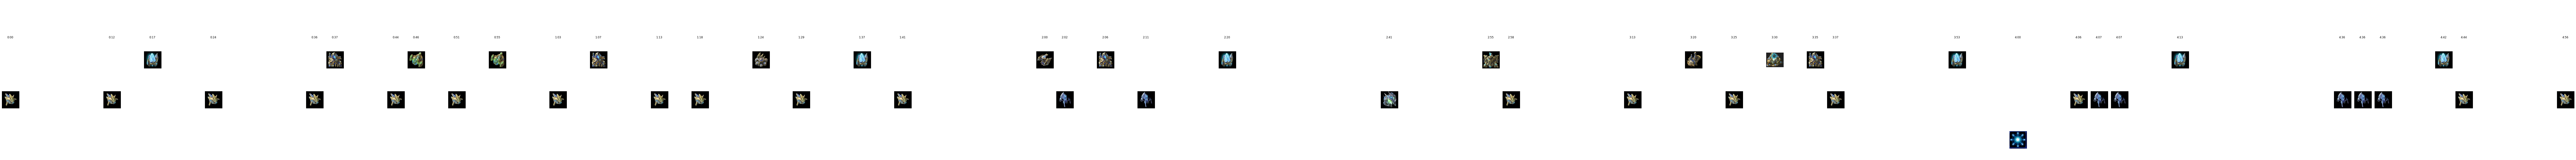

In [22]:
plot_game_series(build_visual_sequence(dummy_BO))

## One-hot encoding

Since the game progresses in discrete frames, we can use one-hot encoding for the sequence of actions taken. However, this greatly increases the length of the timeseries we consider a 10min game has roughtly 13,600 frames in the above example. Most of these frames however have empty action sequences. **To deal with this extremely sparse data, we collapse all gaps between actions and discard those frames.** Although this will affect our accuracy in small (but potentially important) variations to build order, as the name suggests, it is the *order* of actions taken that is of paramount importance. Furthermore, we can append and consider the timeseries of resources as a continuous measure over the duration of the game for improved metrics of how the game is progressing (e.g. dips in minerals and gas will occur when actions are taken).

## Automatic Feature Extraction

We also have packages for automated feature extraction for a time series, e.g. [tsfresh](https://github.com/blue-yonder/tsfresh) is a candidate. To reduce the multivariate nature of the timeseries matrix we ended up with, we can run this feature extraction on each row of our matrix (timeseries for a single variable) then flatten the results into a single vector for further classification.